In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import classification_report, confusion_matrix
import time
%matplotlib inline

## change Data type

In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

## Plot Confusion Matrix


In [4]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

## Read Data from Path

In [5]:
def load_data(path):
    filename = path + 'data_batch_'
    data = [i for i in range(7)]

    for i in range(len(data)):
        if i != 0 and i != 6:
            data[i] = unpickle(filename + str(i))
    
    data[0] = unpickle(path + 'batches.meta')
    data[6] = unpickle(path + 'test_batch')
    # Load all batches(train & test) to a list and return it
    
    return data

In [6]:
# where data stored
data_dir = 'drive/MyDrive/Colab Notebooks/project2_PejmanSamadi/cifar10/'
# data_dir = 'cifar10/'

all_data = load_data(data_dir)

In [7]:
batches = all_data[0]     # label names
label_name = batches[b'label_names']
print(label_name)

[b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']


## Split Data to Train and Valid and Test

In [8]:
def train_test_normal(data):
    
    '''--------------------------------------- split data ----------------------------------------'''
    # attach all data from list to a numpy array X_train, Y_train
    for i in range(1, 6):
        x_data = all_data[i][b'data']
        y_data = np.array(all_data[i][b"labels"])
        if i == 1:
            X_train = x_data
            Y_train = y_data
        else:
            X_train = np.concatenate((X_train, x_data), axis = 0)
            Y_train = np.concatenate((Y_train, y_data), axis = 0)

    # stored test data in X_test, Y_tests
    X_test = all_data[6][b'data']
    Y_test = np.array(all_data[6][b"labels"])
    
    '''------------------------------------ Normalize data ----------------------------------------'''
    # change data shape 3072---> 3, 32, 32 ---> transpose 32, 32, 3
    X_train = X_train.reshape(X_train.shape[0], 3, 32, 32).transpose(0, 2, 3, 1).astype('uint8')
    X_test = X_test.reshape(X_test.shape[0], 3, 32, 32).transpose(0, 2, 3, 1).astype('uint8')
    # Normalize Data
    X_train = X_train / 255.
    X_test = X_test / 255.
    # X = (X - X.min()) / (X.max() - X.min())  ---> X /= 255.0
    # X.min() = 0
    # X.max() = 255
    # Print shape of Data to better Understanding
    print(X_train.shape)
    print(Y_train.shape)
    print("-------")
    print(X_test.shape)
    print(Y_test.shape)
    # return train, test Data
    return X_train, Y_train, X_test, Y_test

In [9]:
X_train, Y_train, X_test, Y_test = train_test_normal(all_data)

(50000, 32, 32, 3)
(50000,)
-------
(10000, 32, 32, 3)
(10000,)


## Visualize Data

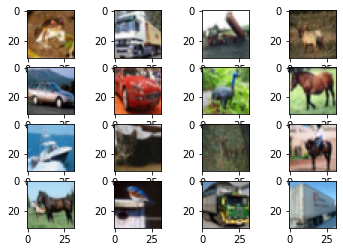

In [10]:
row, column = 4, 4
for i in range(row * column):
    plt.subplot(row, column, i + 1)
    plt.imshow(X_train[i])
plt.show()

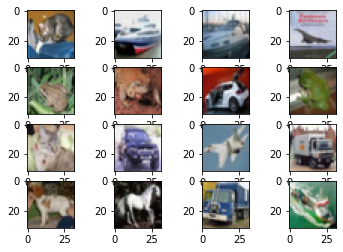

In [11]:
row, column = 4, 4
for i in range(row * column):
    plt.subplot(row, column, i + 1)
    plt.imshow(X_test[i])
plt.show()

## Creat Neural Network

In [12]:
def model_creation(layers, neurons, activation_func):
    # model_creation(2, [256, 128], 'relu')  <---  How inputs are
    model = Sequential(Flatten(input_shape=(32, 32, 3)))
    try:
        if layers > 0:
            for i in range(layers):
                model.add(Dense(neurons[i], activation=activation_func))
                # Hidden Layer Addition
        # output Layer
        model.add(Dense(10, activation='softmax'))
        
        print(model.summary())
        
    except TypeError:
        print('neurons type is list!')
    
    return model

## Train Model and plot Loss

In [13]:
def plot_history(history):
    fig, axs = plt.subplots(2)
    # Plot both Loss & Accuracy in Subplot
  # creat accuracy plot
    axs[0].plot(history.history['acc'], label='train accuracy')
    axs[0].plot(history.history['val_acc'], label='test accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend(loc='lower right')
    axs[0].set_title('Accuracy eval')

  # creat loss plot
    axs[1].plot(history.history['loss'], label='train loss')
    axs[1].plot(history.history['val_loss'], label='test loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(loc='upper right')
    axs[1].set_title('Loss eval')

    plt.show()

In [14]:
def compile_fit_plot(model, learning_Rate, train_data, valid_data, batch_Size, Epochs):
    # Compile model with user learning rate, data, batch_size and epochs
    try:
        model.compile(optimizer=Adam(learning_rate=learning_Rate), loss='sparse_categorical_crossentropy', metrics=['acc'])
        # Visualize model performance in tensorboard
        name = 'cifar 10 model{}'.format(time.ctime())
        tensorCall = TensorBoard(log_dir='logs/{}'.format(name))
        # train model
        history = model.fit(train_data[0], train_data[1], batch_size=batch_Size, 
                             epochs=Epochs, validation_data=valid_data, callbacks=[tensorCall])
    
        # plt.plot(history.history['loss'], 'b-')
        # plt.plot(history.history['val_loss'], 'r-')
        # plt.ylabel('loss')
        
        # plot model Loss and Accuracy in 1 line
        plot_history(history)
        
    except ValueError:
        print('\nvalid_data type is tuple')

## Predict test data and plot Confusion Matrix

In [15]:
def prediction_test(model, test_data):
    # model performance on test Data
    y_predict = model.predict(test_data[0])
    Y_predict = np.argmax(y_predict, axis=1)
    # Plot Confusion Matrix
    confiusionM = confusion_matrix(test_data[1], Y_predict)
    
    plot_confusion_matrix(cm=confiusionM, title='Confiusion', target_names=label_name, normalize=False)

## Model_1: One Layer 

In [ ]:
model_1 = model_creation(1, [300], 'relu')
# one layer with best score on test 

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 300)               921900    
_________________________________________________________________
dense_12 (Dense)             (None, 10)                3010      
Total params: 924,910
Trainable params: 924,910
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/80
782/782 [==============================] - 3s 4ms/step - loss: 1.8874 - acc: 0.3288 - val_loss: 1.7650 - val_acc: 0.3830
Epoch 2/80
782/782 [==============================] - 2s 3ms/step - loss: 1.7210 - acc: 0.3948 - val_loss: 1.6804 - val_acc: 0.4150
Epoch 3/80
782/782 [==============================] - 2s 3ms/step - loss: 1.6481 - acc: 0.4216 - val_loss: 1.6324 - val_acc: 0.4292
Epoch 4/80
782/782 [==============================] - 2s 3ms/step - loss: 1.5988 - acc: 0.4412 - val_loss: 1.5950 - val_acc: 0.4415
Epoch 5/80
782/782 [==============================] - 2s 3ms/step - loss: 1.5623 - acc: 0.4536 - val_loss: 1.5755 - val_acc: 0.4448
Epoch 6/80
782/782 [==============================] - 2s 3ms/step - loss: 1.5292 - acc: 0.4661 - val_loss: 1.5362 - val_acc: 0.4643
Epoch 7/80
782/782 [==============================] - 2s 3ms/step - loss: 1.4984 - acc: 0.4771 - val_loss: 1.5053 - val_acc: 0.4700
Epoch 8/80
782/782 [==============================] - 2s 3ms/step - loss: 1.

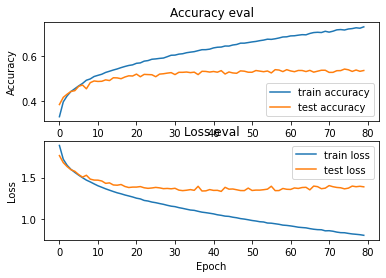

In [ ]:
compile_fit_plot(model_1, 0.0001, [X_train, Y_train], (X_test, Y_test), 64, 80)

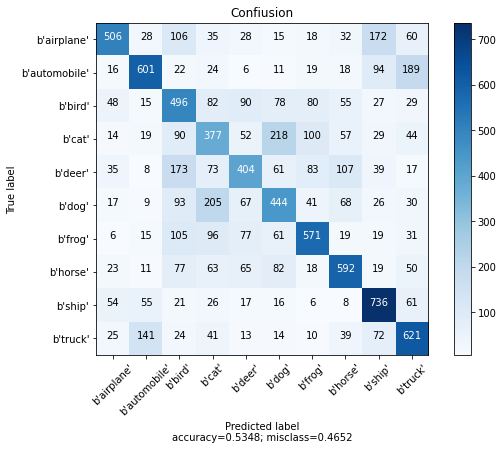

In [ ]:
prediction_test(model_1, [X_test, Y_test])

In [ ]:
y_predict1 = model_1.predict(X_test)
Y_predict1 = np.argmax(y_predict1, axis=1)
# model_"i" score ---> Y_predict"i" 
# for Precision, recall, F1 score

In [ ]:
for i in range(10):
    true_positive = np.sum((Y_predict1 == i) * (Y_test == i))
    true_negative = np.sum((Y_predict1 != i) * (Y_test != i))
    false_positive = np.sum((Y_predict1 == i) * (Y_test != i))
    false_negative = np.sum((Y_predict1 != i) * (Y_test == i))

    acc = (true_positive + true_negative) / (X_test.shape[0]) * 100
    precision = true_positive / (true_positive + false_positive) * 100
    recall = true_positive / (true_positive + false_negative) * 100
    F1 = 2 * ((precision * recall) / (precision + recall))
    
    print('on label {}, acc={:0.2f}, precision={:0.2f}, recall={:0.2f}, F1 Score={:0.2f}'.format(label_name[i], acc, precision, recall, F1))

on label b'airplane', acc=92.68, precision=68.01, recall=50.60, F1 Score=58.03
on label b'automobile', acc=93.00, precision=66.63, recall=60.10, F1 Score=63.20
on label b'bird', acc=87.85, precision=41.09, recall=49.60, F1 Score=44.95
on label b'cat', acc=87.32, precision=36.89, recall=37.70, F1 Score=37.29
on label b'deer', acc=89.89, precision=49.33, recall=40.40, F1 Score=44.42
on label b'dog', acc=88.88, precision=44.40, recall=44.40, F1 Score=44.40
on label b'frog', acc=91.96, precision=60.36, recall=57.10, F1 Score=58.68
on label b'horse', acc=91.89, precision=59.50, recall=59.20, F1 Score=59.35
on label b'ship', acc=92.39, precision=59.69, recall=73.60, F1 Score=65.92
on label b'truck', acc=91.10, precision=54.86, recall=62.10, F1 Score=58.26


In [ ]:
print(classification_report(Y_test, Y_predict1))
# Another way to Precision, recall, F1 score

              precision    recall  f1-score   support

           0       0.68      0.51      0.58      1000
           1       0.67      0.60      0.63      1000
           2       0.41      0.50      0.45      1000
           3       0.37      0.38      0.37      1000
           4       0.49      0.40      0.44      1000
           5       0.44      0.44      0.44      1000
           6       0.60      0.57      0.59      1000
           7       0.59      0.59      0.59      1000
           8       0.60      0.74      0.66      1000
           9       0.55      0.62      0.58      1000

    accuracy                           0.53     10000
   macro avg       0.54      0.53      0.53     10000
weighted avg       0.54      0.53      0.53     10000



## model1 with Dropout to prevent Overfitting & L2 Regularization

## model_1 ---> Overfitting
## model_1 VS model1_improved
## Y_predict1 VS Y_predict1IMP

In [ ]:
# Creat model without function that I wrote with Extra Layers and More Settings
model1_improved = Sequential(Flatten(input_shape=(32, 32, 3)))

model1_improved.add(Dense(300, activation='relu', 
                          kernel_regularizer=tf.keras.regularizers.l2(0.001)))

model1_improved.add(Dropout(0.3))
 
model1_improved.add(Dense(10, activation='softmax'))
    
print(model1_improved.summary())

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_14 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 300)               921900    
_________________________________________________________________
dropout_4 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 10)                3010      
Total params: 924,910
Trainable params: 924,910
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/80
782/782 [==============================] - 3s 4ms/step - loss: 2.3913 - acc: 0.3014 - val_loss: 2.1730 - val_acc: 0.3753
Epoch 2/80
782/782 [==============================] - 3s 3ms/step - loss: 2.1354 - acc: 0.3653 - val_loss: 2.0181 - val_acc: 0.4099
Epoch 3/80
782/782 [==============================] - 3s 3ms/step - loss: 2.0199 - acc: 0.3926 - val_loss: 1.9495 - val_acc: 0.4193
Epoch 4/80
782/782 [==============================] - 3s 3ms/step - loss: 1.9447 - acc: 0.4045 - val_loss: 1.8647 - val_acc: 0.4297
Epoch 5/80
782/782 [==============================] - 3s 3ms/step - loss: 1.8834 - acc: 0.4180 - val_loss: 1.8250 - val_acc: 0.4410
Epoch 6/80
782/782 [==============================] - 3s 3ms/step - loss: 1.8396 - acc: 0.4315 - val_loss: 1.7880 - val_acc: 0.4419
Epoch 7/80
782/782 [==============================] - 3s 3ms/step - loss: 1.8062 - acc: 0.4355 - val_loss: 1.7453 - val_acc: 0.4593
Epoch 8/80
782/782 [==============================] - 3s 3ms/step - loss: 1.

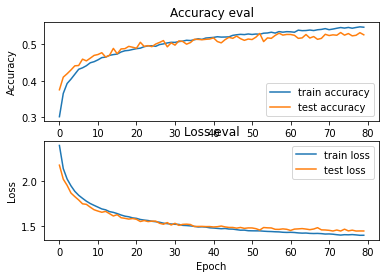

In [ ]:
compile_fit_plot(model1_improved, 0.0001, [X_train, Y_train],
                 (X_test, Y_test), 64, 80)

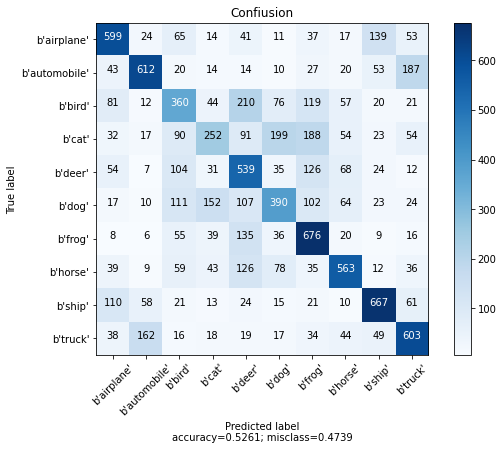

In [ ]:
prediction_test(model1_improved, [X_test, Y_test])

In [ ]:
y_predict1IMP = model1_improved.predict(X_test)
Y_predict1IMP = np.argmax(y_predict1IMP, axis=1)

In [ ]:
for i in range(10):
    true_positive = np.sum((Y_predict1IMP == i) * (Y_test == i))
    true_negative = np.sum((Y_predict1IMP != i) * (Y_test != i))
    false_positive = np.sum((Y_predict1IMP == i) * (Y_test != i))
    false_negative = np.sum((Y_predict1IMP != i) * (Y_test == i))

    acc = (true_positive + true_negative) / (X_test.shape[0]) * 100
    precision = true_positive / (true_positive + false_positive) * 100
    recall = true_positive / (true_positive + false_negative) * 100
    F1 = 2 * ((precision * recall) / (precision + recall))
    
    print('on label {}, acc={:0.2f}, precision={:0.2f}, recall={:0.2f}, F1 Score={:0.2f}'.format(label_name[i], acc, precision, recall, F1))

on label b'airplane', acc=91.77, precision=58.67, recall=59.90, F1 Score=59.28
on label b'automobile', acc=93.07, precision=66.74, recall=61.20, F1 Score=63.85
on label b'bird', acc=88.19, precision=39.96, recall=36.00, F1 Score=37.87
on label b'cat', acc=88.84, precision=40.65, recall=25.20, F1 Score=31.11
on label b'deer', acc=87.72, precision=41.27, recall=53.90, F1 Score=46.75
on label b'dog', acc=89.13, precision=44.98, recall=39.00, F1 Score=41.78
on label b'frog', acc=89.87, precision=49.52, recall=67.60, F1 Score=57.17
on label b'horse', acc=92.09, precision=61.40, recall=56.30, F1 Score=58.74
on label b'ship', acc=93.15, precision=65.46, recall=66.70, F1 Score=66.07
on label b'truck', acc=91.39, precision=56.51, recall=60.30, F1 Score=58.35


In [ ]:
print(classification_report(Y_test, Y_predict1IMP))

              precision    recall  f1-score   support

           0       0.59      0.60      0.59      1000
           1       0.67      0.61      0.64      1000
           2       0.40      0.36      0.38      1000
           3       0.41      0.25      0.31      1000
           4       0.41      0.54      0.47      1000
           5       0.45      0.39      0.42      1000
           6       0.50      0.68      0.57      1000
           7       0.61      0.56      0.59      1000
           8       0.65      0.67      0.66      1000
           9       0.57      0.60      0.58      1000

    accuracy                           0.53     10000
   macro avg       0.53      0.53      0.52     10000
weighted avg       0.53      0.53      0.52     10000



## Model_2: Two layers

In [ ]:
model_2 = model_creation(2, [300, 400], 'relu')
# model 2 has 2 Hidden Layers Best Score on Test

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 300)               921900    
_________________________________________________________________
dense_14 (Dense)             (None, 400)               120400    
_________________________________________________________________
dense_15 (Dense)             (None, 10)                4010      
Total params: 1,046,310
Trainable params: 1,046,310
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/80
782/782 [==============================] - 3s 4ms/step - loss: 1.8473 - acc: 0.3441 - val_loss: 1.7393 - val_acc: 0.3834
Epoch 2/80
782/782 [==============================] - 3s 3ms/step - loss: 1.6606 - acc: 0.4152 - val_loss: 1.6178 - val_acc: 0.4264
Epoch 3/80
782/782 [==============================] - 3s 4ms/step - loss: 1.5829 - acc: 0.4400 - val_loss: 1.5485 - val_acc: 0.4517
Epoch 4/80
782/782 [==============================] - 3s 4ms/step - loss: 1.5286 - acc: 0.4606 - val_loss: 1.5487 - val_acc: 0.4470
Epoch 5/80
782/782 [==============================] - 3s 3ms/step - loss: 1.4824 - acc: 0.4780 - val_loss: 1.4969 - val_acc: 0.4731
Epoch 6/80
782/782 [==============================] - 3s 3ms/step - loss: 1.4440 - acc: 0.4927 - val_loss: 1.4537 - val_acc: 0.4814
Epoch 7/80
782/782 [==============================] - 3s 3ms/step - loss: 1.4105 - acc: 0.5024 - val_loss: 1.4675 - val_acc: 0.4790
Epoch 8/80
782/782 [==============================] - 3s 3ms/step - loss: 1.

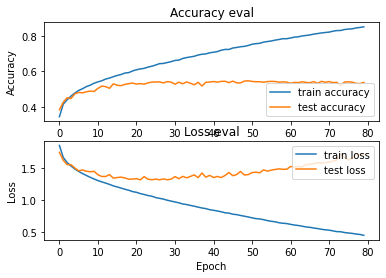

In [ ]:
compile_fit_plot(model_2, 0.0001, [X_train, Y_train], (X_test, Y_test), 64, 80)

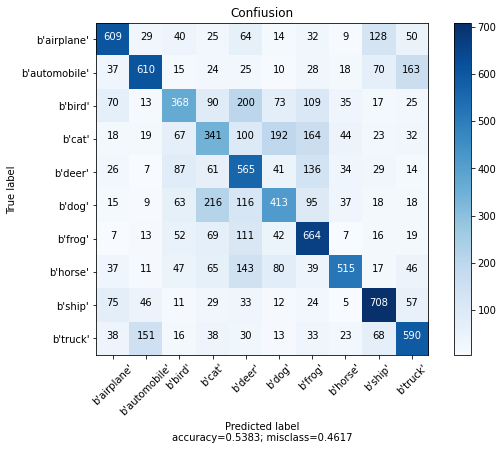

In [ ]:
prediction_test(model_2, [X_test, Y_test])

In [ ]:
y_predict2 = model_2.predict(X_test)
Y_predict2 = np.argmax(y_predict2, axis=1)

In [ ]:
for i in range(10):
    true_positive = np.sum((Y_predict2 == i) * (Y_test == i))
    true_negative = np.sum((Y_predict2 != i) * (Y_test != i))
    false_positive = np.sum((Y_predict2 == i) * (Y_test != i))
    false_negative = np.sum((Y_predict2 != i) * (Y_test == i))

    acc = (true_positive + true_negative) / (X_test.shape[0]) * 100
    precision = true_positive / (true_positive + false_positive) * 100
    recall = true_positive / (true_positive + false_negative) * 100
    F1 = 2 * ((precision * recall) / (precision + recall))
    
    print('on label {}, acc={:0.2f}, precision={:0.2f}, recall={:0.2f}, F1 Score={:0.2f}'.format(label_name[i], acc, precision, recall, F1))

on label b'airplane', acc=92.86, precision=65.34, recall=60.90, F1 Score=63.04
on label b'automobile', acc=93.12, precision=67.18, recall=61.00, F1 Score=63.94
on label b'bird', acc=89.70, precision=48.04, recall=36.80, F1 Score=41.68
on label b'cat', acc=87.24, precision=35.59, recall=34.10, F1 Score=34.83
on label b'deer', acc=87.43, precision=40.74, recall=56.50, F1 Score=47.34
on label b'dog', acc=89.36, precision=46.40, recall=41.30, F1 Score=43.70
on label b'frog', acc=90.04, precision=50.15, recall=66.40, F1 Score=57.14
on label b'horse', acc=93.03, precision=70.84, recall=51.50, F1 Score=59.64
on label b'ship', acc=93.22, precision=64.72, recall=70.80, F1 Score=67.62
on label b'truck', acc=91.66, precision=58.19, recall=59.00, F1 Score=58.59


In [ ]:
print(classification_report(Y_test, Y_predict2))

              precision    recall  f1-score   support

           0       0.65      0.61      0.63      1000
           1       0.67      0.61      0.64      1000
           2       0.48      0.37      0.42      1000
           3       0.36      0.34      0.35      1000
           4       0.41      0.56      0.47      1000
           5       0.46      0.41      0.44      1000
           6       0.50      0.66      0.57      1000
           7       0.71      0.52      0.60      1000
           8       0.65      0.71      0.68      1000
           9       0.58      0.59      0.59      1000

    accuracy                           0.54     10000
   macro avg       0.55      0.54      0.54     10000
weighted avg       0.55      0.54      0.54     10000



## model2 with Dropout to prevent Overfitting & L2 Regularization
## Improving previous model

In [ ]:
model2_improved = Sequential(Flatten(input_shape=(32, 32, 3)))

model2_improved.add(Dense(300, activation='relu', 
                          kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model2_improved.add(Dropout(0.3))

model2_improved.add(Dense(400, activation='relu', 
                    kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model2_improved.add(Dropout(0.3))
    
model2_improved.add(Dense(10, activation='softmax'))
    
print(model2_improved.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_12 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 300)               921900    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 400)               120400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 10)                4010      
Total params: 1,046,310
Trainable params: 1,046,310
Non-trainable params: 0
___________________________________________

Epoch 1/80
782/782 [==============================] - 4s 4ms/step - loss: 2.6793 - acc: 0.2719 - val_loss: 2.3651 - val_acc: 0.3646
Epoch 2/80
782/782 [==============================] - 3s 3ms/step - loss: 2.3062 - acc: 0.3490 - val_loss: 2.1372 - val_acc: 0.4001
Epoch 3/80
782/782 [==============================] - 3s 4ms/step - loss: 2.1489 - acc: 0.3772 - val_loss: 2.0226 - val_acc: 0.4225
Epoch 4/80
782/782 [==============================] - 3s 4ms/step - loss: 2.0438 - acc: 0.3947 - val_loss: 1.9462 - val_acc: 0.4354
Epoch 5/80
782/782 [==============================] - 3s 4ms/step - loss: 1.9690 - acc: 0.4104 - val_loss: 1.8626 - val_acc: 0.4471
Epoch 6/80
782/782 [==============================] - 3s 4ms/step - loss: 1.9109 - acc: 0.4232 - val_loss: 1.8163 - val_acc: 0.4545
Epoch 7/80
782/782 [==============================] - 3s 4ms/step - loss: 1.8666 - acc: 0.4309 - val_loss: 1.7765 - val_acc: 0.4661
Epoch 8/80
782/782 [==============================] - 3s 4ms/step - loss: 1.

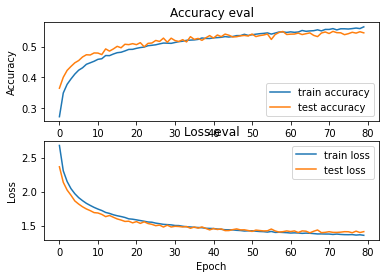

In [ ]:
compile_fit_plot(model2_improved, 0.0001, [X_train, Y_train],
                 (X_test, Y_test), 64, 80)

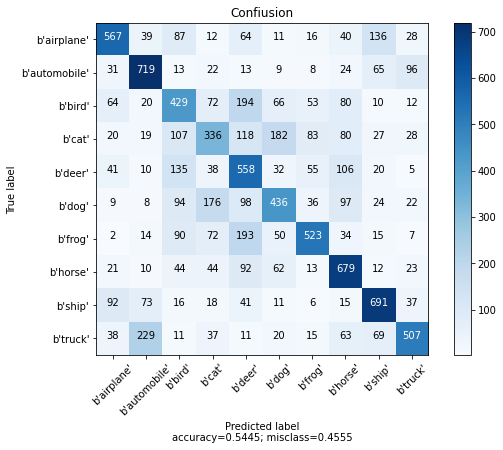

In [ ]:
prediction_test(model2_improved, [X_test, Y_test])

In [ ]:
y_predict2IMP = model2_improved.predict(X_test)
Y_predict2IMP = np.argmax(y_predict2IMP, axis=1)

In [ ]:
for i in range(10):
    true_positive = np.sum((Y_predict2IMP == i) * (Y_test == i))
    true_negative = np.sum((Y_predict2IMP != i) * (Y_test != i))
    false_positive = np.sum((Y_predict2IMP == i) * (Y_test != i))
    false_negative = np.sum((Y_predict2IMP != i) * (Y_test == i))

    acc = (true_positive + true_negative) / (X_test.shape[0]) * 100
    precision = true_positive / (true_positive + false_positive) * 100
    recall = true_positive / (true_positive + false_negative) * 100
    F1 = 2 * ((precision * recall) / (precision + recall))
    
    print('on label {}, acc={:0.2f}, precision={:0.2f}, recall={:0.2f}, F1 Score={:0.2f}'.format(label_name[i], acc, precision, recall, F1))

on label b'airplane', acc=92.49, precision=64.07, recall=56.70, F1 Score=60.16
on label b'automobile', acc=92.97, precision=63.01, recall=71.90, F1 Score=67.16
on label b'bird', acc=88.32, precision=41.81, recall=42.90, F1 Score=42.35
on label b'cat', acc=88.45, precision=40.63, recall=33.60, F1 Score=36.78
on label b'deer', acc=87.34, precision=40.38, recall=55.80, F1 Score=46.85
on label b'dog', acc=89.93, precision=49.60, recall=43.60, F1 Score=46.41
on label b'frog', acc=92.38, precision=64.73, recall=52.30, F1 Score=57.85
on label b'horse', acc=91.40, precision=55.75, recall=67.90, F1 Score=61.23
on label b'ship', acc=93.13, precision=64.64, recall=69.10, F1 Score=66.80
on label b'truck', acc=92.49, precision=66.27, recall=50.70, F1 Score=57.45


In [ ]:
print(classification_report(Y_test, Y_predict2IMP))

              precision    recall  f1-score   support

           0       0.64      0.57      0.60      1000
           1       0.63      0.72      0.67      1000
           2       0.42      0.43      0.42      1000
           3       0.41      0.34      0.37      1000
           4       0.40      0.56      0.47      1000
           5       0.50      0.44      0.46      1000
           6       0.65      0.52      0.58      1000
           7       0.56      0.68      0.61      1000
           8       0.65      0.69      0.67      1000
           9       0.66      0.51      0.57      1000

    accuracy                           0.54     10000
   macro avg       0.55      0.54      0.54     10000
weighted avg       0.55      0.54      0.54     10000



In [46]:
!pip install keras-tuner

     |████████████████████████████████| 96 kB 4.4 MB/s 
  Created wheel for kt-legacy: filename=kt_legacy-1.0.3-py3-none-any.whl size=9568 sha256=062d1aaa3a08abe3eb69d0a5596760659c25ec6e82667ca0feda8da488ef7d37
  Stored in directory: /root/.cache/pip/wheels/38/5c/e0/13003e68c17f403af40b92a24d20171b95fef13b0fdaba833c
Successfully built kt-legacy


## Tuning Hyper Prameters
## Using Keras tunner

In [47]:
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  """Entry point for launching an IPython kernel.


In [ ]:
LOG_DIR = "{}".format(time.ctime())

In [ ]:
def build_model(hp):
    model = Sequential(Flatten(input_shape=(32, 32, 3)))
    model.add(Dense(hp.Int('Layer1', 32, 512, 32), activation='relu'))
    # keras tunner set best parameters and best number of Layers
    for i in range(hp.Int('n_layer', 1, 4)):
        model.add(Dense(hp.Int(f'Layer{i + 1}', 32, 512, 32), activation='relu'))

    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.0001), 
                loss='sparse_categorical_crossentropy',metrics=['acc'])
    return model

In [ ]:
# Tunnig for small part of dataset batch1
x_data1 = all_data[1][b'data']
y_data1 = np.array(all_data[1][b"labels"])

x_data1 = x_data1.reshape(x_data1.shape[0], 3, 32, 32).transpose(0, 2, 3, 1).astype('uint8')
x_data1 = x_data1 / 255.

In [ ]:
tuner1 = RandomSearch(
    build_model,
    objective = 'val_acc',
    max_trials = 1,
    executions_per_trial = 1,
    directory = LOG_DIR
    )

tuner1.search(x=x_data1,
             y=y_data1,
             epochs=10,
             batch_size=64,
             validation_data=(X_test, Y_test))

Trial 1 Complete [00h 00m 14s]
val_acc: 0.3896999955177307

Best val_acc So Far: 0.3896999955177307
Total elapsed time: 00h 00m 14s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner1.get_best_hyperparameters()[0].values

{'Layer1': 352, 'Layer2': 32, 'Layer3': 32, 'Layer4': 32, 'n_layer': 4}

## HP 2
Tunning for One Layer

In [ ]:
LOG_DIR = "2 : {}".format(time.ctime())

In [ ]:
def build_model(hp):
    model = Sequential(Flatten(input_shape=(32, 32, 3)))
    model.add(Dense(hp.Int('Layer1', 32, 512, 32), activation='relu'))

    # for i in range(hp.Int('n_layer', 1, 4)):
      # model.add(Dense(hp.Int(f'Layer{i + 1}', 32, 512, 32), activation='relu'))

    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.0001), 
                loss='sparse_categorical_crossentropy',metrics=['acc'])
    return model

In [ ]:
x_data2 = all_data[2][b'data']
y_data2 = np.array(all_data[2][b"labels"])
# Tunnig for small part of dataset batch2
x_data2 = x_data2.reshape(x_data2.shape[0], 3, 32, 32).transpose(0, 2, 3, 1).astype('uint8')
x_data2 = x_data2 / 255.

In [ ]:
tuner2 = RandomSearch(
    build_model,
    objective = 'val_acc',
    max_trials = 1,
    executions_per_trial = 1,
    directory = LOG_DIR
    )

tuner2.search(x=x_data2,
             y=y_data2,
             epochs=10,
             batch_size=32,
             validation_data=(X_test, Y_test))

Trial 1 Complete [00h 00m 21s]
val_acc: 0.3797999918460846

Best val_acc So Far: 0.3797999918460846
Total elapsed time: 00h 00m 21s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner2.get_best_hyperparameters()[0].values

{'Layer1': 32}

## HP 3

In [ ]:
LOG_DIR = "3 : {}".format(time.ctime())

In [ ]:
def build_model(hp):
    model = Sequential(Flatten(input_shape=(32, 32, 3)))
    model.add(Dense(hp.Int('Layer1', 32, 512, 32), activation='relu'))

    for i in range(hp.Int('n_layer', 1, 5)):
        model.add(Dense(hp.Int(f'Layer{i + 1}', 16, 512, 16), activation='relu'))

    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.0001), 
                loss='sparse_categorical_crossentropy',metrics=['acc'])
    return model

In [ ]:
x_data3 = all_data[3][b'data']
y_data3 = np.array(all_data[3][b"labels"])
# Tunnig for small part of dataset batch3
x_data3 = x_data3.reshape(x_data3.shape[0], 3, 32, 32).transpose(0, 2, 3, 1).astype('uint8')
x_data3 = x_data3 / 255.

In [ ]:
tuner3 = RandomSearch(
    build_model,
    objective = 'val_acc',
    max_trials = 1,
    executions_per_trial = 1,
    directory = LOG_DIR
    )

tuner3.search(x=x_data3,
             y=y_data3,
             epochs=10,
             batch_size=32,
             validation_data=(X_test, Y_test))

Trial 1 Complete [00h 00m 23s]
val_acc: 0.4269999861717224

Best val_acc So Far: 0.4269999861717224
Total elapsed time: 00h 00m 23s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner3.get_best_hyperparameters()[0].values

{'Layer1': 320, 'n_layer': 1}

## HP 4

In [ ]:
LOG_DIR = "4 : {}".format(time.ctime())

In [ ]:
def build_model(hp):
    model = Sequential(Flatten(input_shape=(32, 32, 3)))
    model.add(Dense(hp.Int('Layer1', 32, 512, 32), activation='relu'))

    for i in range(hp.Int('n_layer', 1, 5)):
        model.add(Dense(hp.Int(f'Layer{i + 1}', 16, 512, 16), activation='relu'))

    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.0001), 
                loss='sparse_categorical_crossentropy',metrics=['acc'])
    return model

In [ ]:
x_data4 = all_data[4][b'data']
y_data4 = np.array(all_data[4][b"labels"])
# Tunnig for small part of dataset batch4
x_data4 = x_data4.reshape(x_data4.shape[0], 3, 32, 32).transpose(0, 2, 3, 1).astype('uint8')
x_data4 = x_data4 / 255.

In [ ]:
tuner4 = RandomSearch(
    build_model,
    objective = 'val_acc',
    max_trials = 1,
    executions_per_trial = 1,
    directory = LOG_DIR
    )

tuner4.search(x=x_data4,
             y=y_data4,
             epochs=10,
             batch_size=32,
             validation_data=(X_test, Y_test))

Trial 1 Complete [00h 00m 41s]
val_acc: 0.3587000072002411

Best val_acc So Far: 0.3587000072002411
Total elapsed time: 00h 00m 41s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner4.get_best_hyperparameters()[0].values

{'Layer1': 128, 'Layer2': 16, 'Layer3': 16, 'n_layer': 3}

## HP 5

In [ ]:
LOG_DIR = "5 : {}".format(time.ctime())

In [ ]:
def build_model(hp):
    model = Sequential(Flatten(input_shape=(32, 32, 3)))
    model.add(Dense(hp.Int('Layer1', 32, 512, 32), activation='relu'))

    for i in range(hp.Int('n_layer', 1, 5)):
        model.add(Dense(hp.Int(f'Layer{i + 1}', 16, 512, 16), activation='relu'))

    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.0001), 
                loss='sparse_categorical_crossentropy',metrics=['acc'])
    return model

In [ ]:
x_data5 = all_data[5][b'data']
y_data5 = np.array(all_data[5][b"labels"])
# Tunnig for small part of dataset batch5
x_data5 = x_data5.reshape(x_data5.shape[0], 3, 32, 32).transpose(0, 2, 3, 1).astype('uint8')
x_data5 = x_data5 / 255.

In [ ]:
tuner5 = RandomSearch(
    build_model,
    objective = 'val_acc',
    max_trials = 1,
    executions_per_trial = 1,
    directory = LOG_DIR
    )

tuner5.search(x=x_data5,
             y=y_data5,
             epochs=10,
             batch_size=32,
             validation_data=(X_test, Y_test))

Trial 1 Complete [00h 00m 22s]
val_acc: 0.39250001311302185

Best val_acc So Far: 0.39250001311302185
Total elapsed time: 00h 00m 22s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner5.get_best_hyperparameters()[0].values

{'Layer1': 160, 'Layer2': 16, 'n_layer': 2}

## HP all
## Tunning on all Data

In [ ]:
LOG_DIR = "all : {}".format(time.ctime())

In [ ]:
def build_model(hp):
    model = Sequential(Flatten(input_shape=(32, 32, 3)))
    model.add(Dense(hp.Int('Layer1', 32, 512, 32), activation='relu'))

    for i in range(hp.Int('n_layer', 1, 5)):
        model.add(Dense(hp.Int(f'Layer{i + 1}', 16, 512, 16), activation='relu'))

    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.0001), 
                loss='sparse_categorical_crossentropy',metrics=['acc'])
    return model

In [ ]:
tunerAll = RandomSearch(
    build_model,
    objective = 'val_acc',
    max_trials = 1,
    executions_per_trial = 1,
    directory = LOG_DIR
    )

tunerAll.search(x=X_train,
             y=Y_train,
             epochs=10,
             batch_size=32,
             validation_data=(X_test, Y_test))

Trial 1 Complete [00h 01m 14s]
val_acc: 0.47029998898506165

Best val_acc So Far: 0.47029998898506165
Total elapsed time: 00h 01m 14s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tunerAll.get_best_hyperparameters()[0].values

{'Layer1': 256, 'Layer2': 16, 'Layer3': 16, 'n_layer': 3}

## tanh 
## Tunning on "tanh" for activation
## All Data

In [ ]:
LOG_DIR = "all Th: {}".format(time.ctime())

In [ ]:
def build_model(hp):
    model = Sequential(Flatten(input_shape=(32, 32, 3)))
    model.add(Dense(hp.Int('Layer1', 32, 512, 32), activation='tanh'))

    for i in range(hp.Int('n_layer', 1, 5)):
        model.add(Dense(hp.Int(f'Layer{i + 1}', 16, 512, 16), activation='tanh'))

    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.0001), 
                loss='sparse_categorical_crossentropy',metrics=['acc'])
    return model

In [ ]:
tunerAllth = RandomSearch(
    build_model,
    objective = 'val_acc',
    max_trials = 1,
    executions_per_trial = 1,
    directory = LOG_DIR
    )

tunerAllth.search(x=X_train,
             y=Y_train,
             epochs=10,
             batch_size=32,
             validation_data=(X_test, Y_test))

Trial 1 Complete [00h 01m 09s]
val_acc: 0.48660001158714294

Best val_acc So Far: 0.48660001158714294
Total elapsed time: 00h 01m 09s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tunerAllth.get_best_hyperparameters()[0].values

{'Layer1': 224, 'Layer2': 16, 'n_layer': 2}

## Sigmoid
## Tunning on "sigmoid" for activation
## all Data

In [ ]:
LOG_DIR = "all sig: {}".format(time.ctime())

In [ ]:
def build_model(hp):
    model = Sequential(Flatten(input_shape=(32, 32, 3)))
    model.add(Dense(hp.Int('Layer1', 32, 512, 32), activation='tanh'))

    for i in range(hp.Int('n_layer', 1, 5)):
        model.add(Dense(hp.Int(f'Layer{i + 1}', 16, 512, 16), activation='tanh'))

    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.0001), 
                loss='sparse_categorical_crossentropy',metrics=['acc'])
    return model

In [ ]:
tunerAllsig = RandomSearch(
    build_model,
    objective = 'val_acc',
    max_trials = 1,
    executions_per_trial = 1,
    directory = LOG_DIR
    )

tunerAllsig.search(x=X_train,
             y=Y_train,
             epochs=10,
             batch_size=32,
             validation_data=(X_test, Y_test))

Trial 1 Complete [00h 01m 23s]
val_acc: 0.48240000009536743

Best val_acc So Far: 0.48240000009536743
Total elapsed time: 00h 01m 23s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tunerAllsig.get_best_hyperparameters()[0].values

{'Layer1': 352, 'Layer2': 16, 'Layer3': 16, 'Layer4': 16, 'n_layer': 4}

## ANN VS. CNN
maximum accuracy for ann (with my test) is 60%
Therefore I use CNN before ANN to process data and get better Results

## CNN

In [16]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [17]:
model_cnn = Sequential([
                        Conv2D(filters=32, kernel_size=(3, 3), 
                               activation='relu', input_shape=(32, 32, 3), 
                               padding='same'),
                        Conv2D(filters=32, kernel_size=(3, 3), 
                               activation='relu', padding='same'),
                        MaxPooling2D((2, 2)),

                        Conv2D(filters=64, kernel_size=(3, 3), 
                               activation='relu', padding='same'),
                        Conv2D(filters=64, kernel_size=(3, 3), 
                               activation='relu', padding='same'),
                        MaxPooling2D((2, 2)),
                        
                        Conv2D(filters=128, kernel_size=(3, 3), 
                               activation='relu', padding='same'),
                        Conv2D(filters=128, kernel_size=(3, 3), 
                               activation='relu', padding='same'),
                        MaxPooling2D((2, 2)),
                        
                        Flatten(),
                        Dense(300, activation='relu'),
                        Dense(400, activation='relu'), 
                        Dense(10, activation='softmax')

])
# (Conv + Relu) -> Pooling, (Conv + Relu) -> Pooling, (Conv + Relu) -> Pooling ---> ANN ---> Output 

In [18]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         7

In [22]:
model_cnn.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), 
                  loss='sparse_categorical_crossentropy',
                  metrics=['acc'])

In [23]:
history_cnn = model_cnn.fit(X_train, Y_train, batch_size=64, epochs=80,
              validation_data=(X_test, Y_test))

Epoch 1/80
782/782 [==============================] - 38s 9ms/step - loss: 2.1521 - acc: 0.2054 - val_loss: 1.9486 - val_acc: 0.2965
Epoch 2/80
782/782 [==============================] - 6s 8ms/step - loss: 1.8146 - acc: 0.3480 - val_loss: 1.8119 - val_acc: 0.3443
Epoch 3/80
782/782 [==============================] - 6s 8ms/step - loss: 1.5883 - acc: 0.4318 - val_loss: 1.4803 - val_acc: 0.4725
Epoch 4/80
782/782 [==============================] - 6s 8ms/step - loss: 1.4396 - acc: 0.4860 - val_loss: 1.5321 - val_acc: 0.4740
Epoch 5/80
782/782 [==============================] - 6s 8ms/step - loss: 1.3482 - acc: 0.5171 - val_loss: 1.3327 - val_acc: 0.5274
Epoch 6/80
782/782 [==============================] - 6s 8ms/step - loss: 1.2672 - acc: 0.5496 - val_loss: 1.2527 - val_acc: 0.5590
Epoch 7/80
782/782 [==============================] - 7s 8ms/step - loss: 1.1952 - acc: 0.5777 - val_loss: 1.2292 - val_acc: 0.5703
Epoch 8/80
782/782 [==============================] - 6s 8ms/step - loss: 1

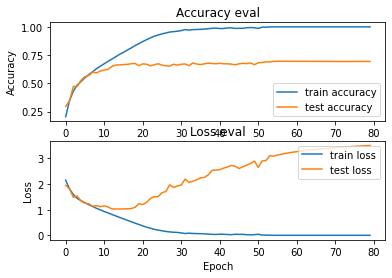

In [24]:
plot_history(history_cnn)

## Accuracy improved but we have Overfitting Problem

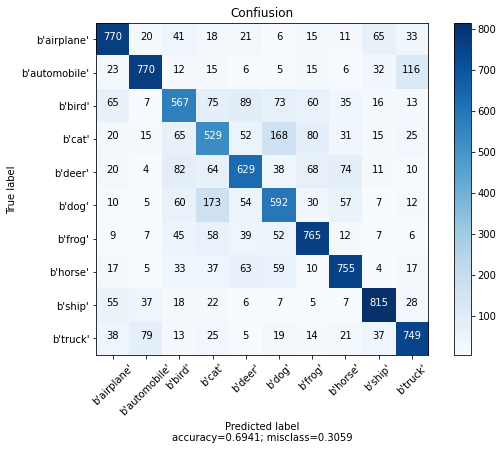

In [25]:
prediction_test(model_cnn, [X_test, Y_test])

In [26]:
y_predict_cnn = model_cnn.predict(X_test)
Y_predict_cnn = np.argmax(y_predict_cnn, axis=1)

In [27]:
for i in range(10):
    true_positive = np.sum((Y_predict_cnn == i) * (Y_test == i))
    true_negative = np.sum((Y_predict_cnn != i) * (Y_test != i))
    false_positive = np.sum((Y_predict_cnn == i) * (Y_test != i))
    false_negative = np.sum((Y_predict_cnn != i) * (Y_test == i))

    acc = (true_positive + true_negative) / (X_test.shape[0]) * 100
    precision = true_positive / (true_positive + false_positive) * 100
    recall = true_positive / (true_positive + false_negative) * 100
    F1 = 2 * ((precision * recall) / (precision + recall))
    
    print('on label {},  acc={:0.2f},   precision={:0.2f},  recall={:0.2f},  F1 Score={:0.2f}'.format(label_name[i], acc, precision, recall, F1))

on label b'airplane',  acc=95.13,   precision=74.98,  recall=77.00,  F1 Score=75.97
on label b'automobile',  acc=95.91,   precision=81.14,  recall=77.00,  F1 Score=79.01
on label b'bird',  acc=91.98,   precision=60.58,  recall=56.70,  F1 Score=58.57
on label b'cat',  acc=90.42,   precision=52.07,  recall=52.90,  F1 Score=52.48
on label b'deer',  acc=92.94,   precision=65.25,  recall=62.90,  F1 Score=64.05
on label b'dog',  acc=91.65,   precision=58.10,  recall=59.20,  F1 Score=58.64
on label b'frog',  acc=94.68,   precision=72.03,  recall=76.50,  F1 Score=74.20
on label b'horse',  acc=95.01,   precision=74.83,  recall=75.50,  F1 Score=75.16
on label b'ship',  acc=96.21,   precision=80.77,  recall=81.50,  F1 Score=81.13
on label b'truck',  acc=94.89,   precision=74.23,  recall=74.90,  F1 Score=74.56


In [28]:
print(classification_report(Y_test, Y_predict_cnn))

              precision    recall  f1-score   support

           0       0.75      0.77      0.76      1000
           1       0.81      0.77      0.79      1000
           2       0.61      0.57      0.59      1000
           3       0.52      0.53      0.52      1000
           4       0.65      0.63      0.64      1000
           5       0.58      0.59      0.59      1000
           6       0.72      0.77      0.74      1000
           7       0.75      0.76      0.75      1000
           8       0.81      0.81      0.81      1000
           9       0.74      0.75      0.75      1000

    accuracy                           0.69     10000
   macro avg       0.69      0.69      0.69     10000
weighted avg       0.69      0.69      0.69     10000



## CNN with Dropout to prevent Overfitting

In [29]:
model_cnnIMP = Sequential([
                        Conv2D(filters=32, kernel_size=(3, 3), 
                               activation='relu', input_shape=(32, 32, 3), padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                        
                        Conv2D(filters=32, kernel_size=(3, 3), 
                               activation='relu', padding='same',
                               kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                        
                        Dropout(0.3),
                        MaxPooling2D((2, 2)),

                        Conv2D(filters=64, kernel_size=(3, 3), 
                               activation='relu', padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                        
                        Conv2D(filters=64, kernel_size=(3, 3), 
                               activation='relu', padding='same',
                               kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                        
                        Dropout(0.3),
                        MaxPooling2D((2, 2)),

                        Conv2D(filters=128, kernel_size=(3, 3), 
                               activation='relu', padding='same',
                               kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                        Conv2D(filters=128, kernel_size=(3, 3), 
                               activation='relu', padding='same',
                               kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                        Dropout(0.3),
                        MaxPooling2D((2, 2)),
                        
                        Flatten(),
                        Dense(300, activation='relu', 
                              kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                        Dropout(0.3),
                        Dense(400, activation='relu', 
                              kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                        Dropout(0.3),
                        Dense(10, activation='softmax')

])

In [30]:
model_cnnIMP.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)       

In [31]:
model_cnnIMP.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), 
                  loss='sparse_categorical_crossentropy',
                  metrics=['acc'])

In [ ]:
history_cnnIMP = model_cnnIMP.fit(X_train, Y_train, batch_size=64, epochs=80,
              validation_data=(X_test, Y_test))

Epoch 1/80
782/782 [==============================] - 9s 10ms/step - loss: 3.3712 - acc: 0.1853 - val_loss: 3.2690 - val_acc: 0.2933
Epoch 2/80
782/782 [==============================] - 8s 10ms/step - loss: 3.0819 - acc: 0.3019 - val_loss: 3.0852 - val_acc: 0.3693
Epoch 3/80
782/782 [==============================] - 8s 10ms/step - loss: 2.8800 - acc: 0.3649 - val_loss: 2.9274 - val_acc: 0.4320
Epoch 4/80
782/782 [==============================] - 7s 10ms/step - loss: 2.7264 - acc: 0.4115 - val_loss: 2.7919 - val_acc: 0.4625
Epoch 5/80
782/782 [==============================] - 7s 10ms/step - loss: 2.6095 - acc: 0.4422 - val_loss: 2.7967 - val_acc: 0.4559
Epoch 6/80
782/782 [==============================] - 8s 10ms/step - loss: 2.5074 - acc: 0.4694 - val_loss: 2.6118 - val_acc: 0.5107
Epoch 7/80
782/782 [==============================] - 8s 10ms/step - loss: 2.4216 - acc: 0.4933 - val_loss: 2.5384 - val_acc: 0.5109
Epoch 8/80
782/782 [==============================] - 7s 10ms/step - 

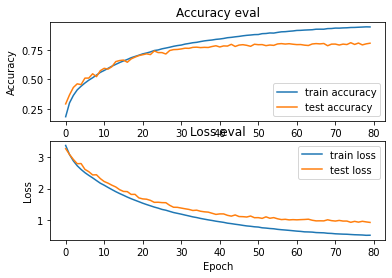

In [38]:
plot_history(history_cnnIMP)

## model Overfitting improved

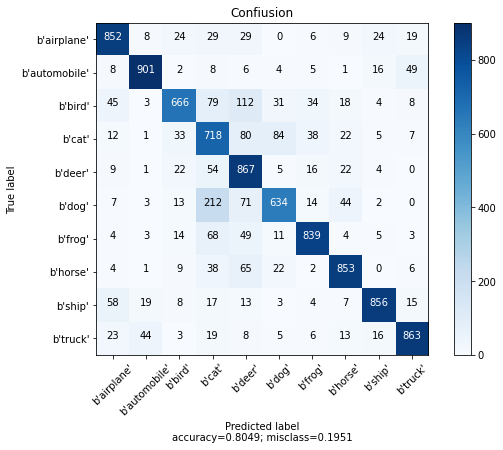

In [39]:
prediction_test(model_cnnIMP, [X_test, Y_test])

In [40]:
y_predict_cnnIMP = model_cnnIMP.predict(X_test)
Y_predict_cnnIMP = np.argmax(y_predict_cnnIMP, axis=1)

In [41]:
for i in range(10):
    true_positive = np.sum((Y_predict_cnnIMP == i) * (Y_test == i))
    true_negative = np.sum((Y_predict_cnnIMP != i) * (Y_test != i))
    false_positive = np.sum((Y_predict_cnnIMP == i) * (Y_test != i))
    false_negative = np.sum((Y_predict_cnnIMP != i) * (Y_test == i))

    acc = (true_positive + true_negative) / (X_test.shape[0]) * 100
    precision = true_positive / (true_positive + false_positive) * 100
    recall = true_positive / (true_positive + false_negative) * 100
    F1 = 2 * ((precision * recall) / (precision + recall))
    
    print('on label {},  acc={:0.2f},   precision={:0.2f},  recall={:0.2f},  F1 Score={:0.2f}'.format(label_name[i], acc, precision, recall, F1))

on label b'airplane',  acc=96.82,   precision=83.37,  recall=85.20,  F1 Score=84.27
on label b'automobile',  acc=98.18,   precision=91.57,  recall=90.10,  F1 Score=90.83
on label b'bird',  acc=95.38,   precision=83.88,  recall=66.60,  F1 Score=74.25
on label b'cat',  acc=91.94,   precision=57.81,  recall=71.80,  F1 Score=64.05
on label b'deer',  acc=94.34,   precision=66.69,  recall=86.70,  F1 Score=75.39
on label b'dog',  acc=94.69,   precision=79.35,  recall=63.40,  F1 Score=70.48
on label b'frog',  acc=97.14,   precision=87.03,  recall=83.90,  F1 Score=85.44
on label b'horse',  acc=97.13,   precision=85.90,  recall=85.30,  F1 Score=85.60
on label b'ship',  acc=97.80,   precision=91.85,  recall=85.60,  F1 Score=88.61
on label b'truck',  acc=97.56,   precision=88.97,  recall=86.30,  F1 Score=87.61


In [42]:
print(classification_report(Y_test, Y_predict_cnnIMP))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1000
           1       0.92      0.90      0.91      1000
           2       0.84      0.67      0.74      1000
           3       0.58      0.72      0.64      1000
           4       0.67      0.87      0.75      1000
           5       0.79      0.63      0.70      1000
           6       0.87      0.84      0.85      1000
           7       0.86      0.85      0.86      1000
           8       0.92      0.86      0.89      1000
           9       0.89      0.86      0.88      1000

    accuracy                           0.80     10000
   macro avg       0.82      0.80      0.81     10000
weighted avg       0.82      0.80      0.81     10000



## CNN with hyperparameters Tuning (keras tuner)
## Like Previous Tunning 

In [49]:
LOG_DIR = "{}".format(time.ctime())

In [50]:
def build_modelcnn(hp):
    model = Sequential([
                        Conv2D(filters=hp.Int('conv_1_filter', 32, 128, 16), 
                     kernel_size=hp.Choice('cov_1_kernel', values = [3, 5]), 
                     activation='relu', input_shape=(32, 32, 3)),
                        
                        Conv2D(filters=hp.Int('conv_2_filter', 32, 64, 16), 
                     kernel_size=hp.Choice('cov_2_kernel', values = [3, 5]), 
                     activation='relu'),
                        
                        Flatten(),

                        Dense(units=hp.Int('dense_layer1', 32, 128, 16), 
                              activation='relu'),

                        Dense(10, activation='softmax')])

    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])), 
                loss='sparse_categorical_crossentropy',metrics=['acc'])
    
    return model

In [52]:
tuner_search = RandomSearch(build_modelcnn, objective='val_acc', 
                            max_trials=5, directory=LOG_DIR)

In [53]:
tuner_search.search(X_train, Y_train, epochs=3, validation_data=(X_test, Y_test))

Trial 5 Complete [00h 00m 26s]
val_acc: 0.6481999754905701

Best val_acc So Far: 0.6481999754905701
Total elapsed time: 00h 03m 00s
INFO:tensorflow:Oracle triggered exit


In [54]:
tuner_search.get_best_hyperparameters()[0].values

{'conv_1_filter': 48,
 'conv_2_filter': 64,
 'cov_1_kernel': 3,
 'cov_2_kernel': 3,
 'dense_layer1': 64,
 'learning_rate': 0.001}

In [56]:
model_cnn_tunned = Sequential([
                Conv2D(48, kernel_size=3, 
                     activation='relu', input_shape=(32, 32, 3)),
                        
                Conv2D(64, kernel_size=3, activation='relu'),
                        
                Flatten(),

                Dense(units=64, activation='relu'),

                Dense(10, activation='softmax')])

In [57]:
model_cnn_tunned.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 48)        1344      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        27712     
_________________________________________________________________
flatten_2 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                3211328   
_________________________________________________________________
dense_5 (Dense)              (None, 10)                650       
Total params: 3,241,034
Trainable params: 3,241,034
Non-trainable params: 0
_________________________________________________________________


In [59]:
model_cnn_tunned.compile(optimizer=Adam(0.001), 
                loss='sparse_categorical_crossentropy',metrics=['acc'])

In [60]:
history_cnn_tunned = model_cnn_tunned.fit(X_train, Y_train, 
                                          batch_size=32, epochs=80, 
                                          validation_data=(X_test, Y_test))

Epoch 1/80
1563/1563 [==============================] - 8s 5ms/step - loss: 1.3932 - acc: 0.5033 - val_loss: 1.1219 - val_acc: 0.6061
Epoch 2/80
1563/1563 [==============================] - 8s 5ms/step - loss: 0.9994 - acc: 0.6497 - val_loss: 1.0308 - val_acc: 0.6409
Epoch 3/80
1563/1563 [==============================] - 7s 5ms/step - loss: 0.7997 - acc: 0.7187 - val_loss: 1.0292 - val_acc: 0.6494
Epoch 4/80
1563/1563 [==============================] - 7s 5ms/step - loss: 0.6227 - acc: 0.7817 - val_loss: 1.0706 - val_acc: 0.6506
Epoch 5/80
1563/1563 [==============================] - 8s 5ms/step - loss: 0.4586 - acc: 0.8405 - val_loss: 1.2308 - val_acc: 0.6350
Epoch 6/80
1563/1563 [==============================] - 8s 5ms/step - loss: 0.3239 - acc: 0.8876 - val_loss: 1.4647 - val_acc: 0.6234
Epoch 7/80
1563/1563 [==============================] - 8s 5ms/step - loss: 0.2179 - acc: 0.9257 - val_loss: 1.7297 - val_acc: 0.6236
Epoch 8/80
1563/1563 [==============================] - 8s 5ms

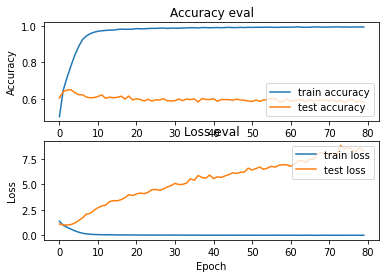

In [61]:
plot_history(history_cnn_tunned)

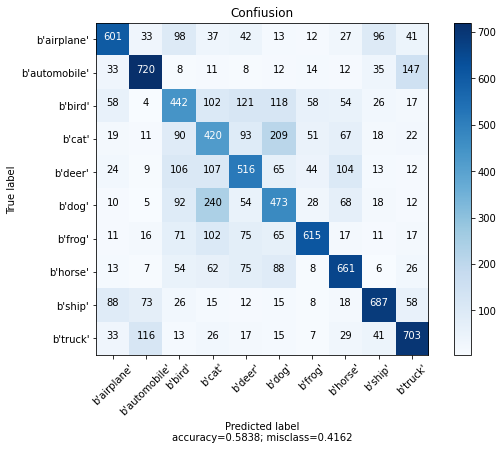

In [62]:
prediction_test(model_cnn_tunned, [X_test, Y_test])

In [63]:
y_predict_cnn_tunned = model_cnn_tunned.predict(X_test)
Y_predict_cnn_tunned = np.argmax(y_predict_cnn_tunned, axis=1)

In [64]:
for i in range(10):
    true_positive = np.sum((Y_predict_cnn_tunned == i) * (Y_test == i))
    true_negative = np.sum((Y_predict_cnn_tunned != i) * (Y_test != i))
    false_positive = np.sum((Y_predict_cnn_tunned == i) * (Y_test != i))
    false_negative = np.sum((Y_predict_cnn_tunned != i) * (Y_test == i))

    acc = (true_positive + true_negative) / (X_test.shape[0]) * 100
    precision = true_positive / (true_positive + false_positive) * 100
    recall = true_positive / (true_positive + false_negative) * 100
    F1 = 2 * ((precision * recall) / (precision + recall))
    
    print('on label {},  acc={:0.2f},   precision={:0.2f},  recall={:0.2f},  F1 Score={:0.2f}'.format(label_name[i], acc, precision, recall, F1))

on label b'airplane',  acc=93.12,   precision=67.53,  recall=60.10,  F1 Score=63.60
on label b'automobile',  acc=94.46,   precision=72.43,  recall=72.00,  F1 Score=72.22
on label b'bird',  acc=88.84,   precision=44.20,  recall=44.20,  F1 Score=44.20
on label b'cat',  acc=87.18,   precision=37.43,  recall=42.00,  F1 Score=39.59
on label b'deer',  acc=90.19,   precision=50.94,  recall=51.60,  F1 Score=51.27
on label b'dog',  acc=88.73,   precision=44.08,  recall=47.30,  F1 Score=45.63
on label b'frog',  acc=93.85,   precision=72.78,  recall=61.50,  F1 Score=66.67
on label b'horse',  acc=92.65,   precision=62.54,  recall=66.10,  F1 Score=64.27
on label b'ship',  acc=94.23,   precision=72.24,  recall=68.70,  F1 Score=70.43
on label b'truck',  acc=93.51,   precision=66.64,  recall=70.30,  F1 Score=68.42


In [65]:
print(classification_report(Y_test, Y_predict_cnn_tunned))

              precision    recall  f1-score   support

           0       0.68      0.60      0.64      1000
           1       0.72      0.72      0.72      1000
           2       0.44      0.44      0.44      1000
           3       0.37      0.42      0.40      1000
           4       0.51      0.52      0.51      1000
           5       0.44      0.47      0.46      1000
           6       0.73      0.61      0.67      1000
           7       0.63      0.66      0.64      1000
           8       0.72      0.69      0.70      1000
           9       0.67      0.70      0.68      1000

    accuracy                           0.58     10000
   macro avg       0.59      0.58      0.59     10000
weighted avg       0.59      0.58      0.59     10000

